## 이미지 코너 검출
---
* 이미지의 특성은 코너/꼭지점 부분에서 잘 나타남
* -> 코너를 검출할 수 있다면 이미지의 특성을 파악할 수 있음


### Harris Corner Dectection
---
* '코너 = 이미지에서 intensity(강렬한 정도)의 변화가 큰 영역' 임을 이용해 코너를 검출하는 기법

* 임의 크기로 설정된 창(window)를 x축으로 $\Delta x$만큼, y축으로 $\Delta y$만큼 이동시켰을 때 창 안의 각 픽셀의 차이의 제곱을 모두 합하여 변화량 $E(\Delta x,\Delta y)$를 구하고, 이 값이 크면 코너라고 판단함

$$E(\Delta x,\Delta y) = \sum_{(x_k, y_k)\in W} \underbrace{w((x_k, y_k))}_\text{window function} \, [\underbrace{I(x_k+\Delta x,y_k+\Delta y)}_\text{shifted intensity}-\underbrace{I(x_k,y_k)}_\text{intensity}]^2$$
* 여기서 $w(x_k, y_k)$, window function은 창 내의 픽셀들에 가중치를 주기 위한 [커널 함수](https://darkpgmr.tistory.com/147 "언젠가 내용 따로 정리해보기")로 직사각형 커널이나 가우시안 커널이 사용됨
  * 창 내의 픽셀들 전처리한다는 느낌 -> 빼고 정리

$$E(\Delta x,\Delta y) = \sum_W [I(x_k+\Delta x,y_k+\Delta y)-I(x_k,y_k)]^2$$

* 식을 테일러 전개하고 정리하면 아래와 같은 형태로 정리됨

$$\begin{align*}  E(\Delta x, \Delta y) &= \sum _{W} [I(x_k+\Delta x,y_k+\Delta y)-I(x_k,y_k)]^2   \\    &\approx \begin{bmatrix}  \Delta x & \Delta y  \end{bmatrix}  \begin{bmatrix}  \sum I_x(x_k,y_k)^2 & \sum I_x(x_k,y_k)I_y(x_k,y_k)\\   \sum I_x(x_k,y_k)I_y(x_k,y_k) & \sum I_y(x_k,y_k)^2  \end{bmatrix}  \begin{bmatrix}  \Delta x\\   \Delta y  \end{bmatrix}   \\    &= \begin{bmatrix}  \Delta x & \Delta y  \end{bmatrix} M \begin{bmatrix}  \Delta x\\   \Delta y  \end{bmatrix}  \end{align*}$$

$$M = \sum_{W} \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}$$

* $I_x$와 $I_y$는 이미지 픽셀 $(x, y)$에서 x방향, y방향으로의 편미분 값
  - 이는 ```cv2.Sobel()```로 쉽게 찾을 수 있음
  
* 이때 식 $M$의 고유값을 분해해 2개의 고유값 $\lambda_1$, $\lambda_2$과 그에 상응하는 고유 벡터를 얻을 수 있는데, 둘중 더 큰 고유값과 연결된 고유벡터 방향으로의 이미지 변화가 더 크다는 의미임
* 따라서 
  - $\lambda_1$, $\lambda_2$ 값이 둘다 작을 때 평면이라 판단함
  - $\lambda_1$이 $\lambda_2$보다 충분히 크거나 그 반대일 때 엣지로 판단함
  - $\lambda_1$과 $\lambda_2$모두 충분히 크고 두 값이 비슷할 때 코너로 판단함

* 이를 바탕으로 엣지임을 판별하기 위한 식을 세우면 아래와 같이 됨
$$ R = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2$$

* 이때 두 고유값을 따로 구하려면 복잡하므로 $det(M) = \lambda_1 \lambda_2$, $trace(M) = \lambda_1 + \lambda_2$을 이용해 결과적으로 아래와 같은 식이 구해짐
$$ R = det(M) − k(trace(M))^2 $$

* R 값에 따라 평면/엣지/코너를 판단함

  * ![평면/모서리/코너일때의 $\lambda_1$, $\lambda_2$ 값의 특징](https://docs.opencv.org/master/harris_region.jpg)

```cv2.cornerHarris(img, blockSize, ksize, k)```
* img: 입력 이미지
* blockSize: 코너 검출시에 고려할 이웃의 크기
    * window size?
* ksize: sobel 미분에 사용될 매개변수
* k: Harris Corner Dectecion 식의 매개변수 k

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# 성능이 한참 떨어짐
# 기능상은 문제 없는듯?
def cornerHarris_my(img, blockSize, ksize, k, checkProg=False):
    sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=ksize)
    sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=ksize)

    res = np.empty_like(img)
    
    for y in range(len(img)):
        for x in range(len(img[0])):
            yb, ye = y-blockSize+1, y+blockSize
            xb, xe = x-blockSize+1, x+blockSize

            Ix = sobelx[yb:ye, xb:xe]
            Iy = sobely[yb:ye, xb:xe]

            m = np.array([[np.sum(Ix**2), np.sum(Ix*Iy)],
                          [np.sum(Ix*Iy), np.sum(Iy**2)]])

            r = np.linalg.det(m) - k*m.trace()
            res[y, x] = r
        
        #for checking progression
        if y%(len(img)//10) == 0 and checkProg:
            print("@", end="")
            
    return res

In [2]:
imgDir = '../image/'
rawImg = cv.imread(imgDir+'building.jpg')
gray = cv.cvtColor(rawImg, cv.COLOR_BGR2GRAY)

gray = np.float32(gray)

In [3]:
dst = cv.cornerHarris(gray, 2, 3, 0.04)
dst = cv.dilate(dst, None)

img = rawImg.copy()
img[dst > 0.01*dst.max()] = [0, 0, 255]

In [4]:
dst_my = cornerHarris_my(gray, 2, 3, 0.04)
dst_my = cv.dilate(dst_my, None)

img_my = rawImg.copy()
img_my[dst_my > 0.01*dst_my.max()] = [0, 0, 255]

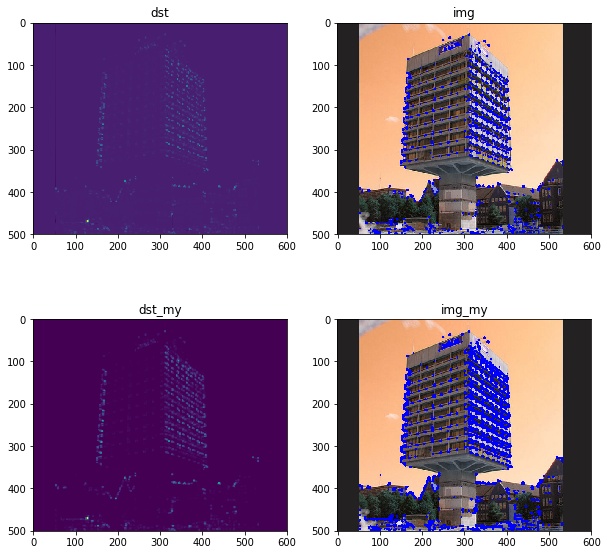

In [5]:
fig1 = plt.figure( figsize=(10, 10) )

ax11 = fig1.add_subplot(2,2,1)
ax11.imshow(dst, interpolation="none")
ax11.set_title("dst")

ax12 = fig1.add_subplot(2,2,2)
ax12.imshow(img, interpolation="none")
ax12.set_title("img")

ax21 = fig1.add_subplot(2,2,3)
ax21.imshow(dst_my, interpolation="none")
ax21.set_title("dst_my")

ax22 = fig1.add_subplot(2,2,4)
ax22.imshow(img_my, interpolation="none")
ax22.set_title("img_my")

plt.show()

#### Corner with [SubPixel](https://www.pomeas.com/newsview/529.html) Accuracy

* 위의 두 결과 이미지 모두 동일한 지점에 점이 여러개 찍히는 현상이 나타난다.
* 더욱 정확한(Sub Pixel 수준의) 결과를 위해 동일 코너에 있는 여러 점들 중 가장 정확한 점만을 남기기 위한 방법이 필요함
* 비슷한 지점의 점들의 중심점만을 남기는 방법

* 중심 q로부터 이웃된 점 p로의 모든 벡터들이 이미지와 측정 노이즈에 대한 p에서의 이미지 gradient에 직교한다는 점을 통해 SubPixel 수준의 정확도를 가지는 코너를 검출할 수 있다. 이를 바탕으로 수식을 세워보면 아래와 같음
$$\epsilon _i = {DI_{p_i}}^T \cdot (q - p_i)$$

  * $DI_{p_i}$: q의 이웃 중 하나인 $p_i$에서의 이미지 gradient

* $\epsilon _i$가 최소화되는 q값을 찾야 하므로, $\epsilon _i$가 0이 되도록 하면 아래의 식이 됨
$$\sum _i(DI_{p_i} \cdot {DI_{p_i}}^T) \cdot q - \sum _i(DI_{p_i} \cdot {DI_{p_i}}^T \cdot p_i)$$

* gradient들은 q의 이웃(search window 내의)들과 합산된다
* 이때 첫 번째 gradient 항을 G, 두 번째 gradient 항을 b라 하면,
$$ q = G^{-1} \cdot b$$

* 새로 구해진 q를 중심으로 search window를 설정하고, 중심이 지정한 임계값에 도달할 때까지 이 과정을 반복함

```cv2.cornerSubPix(img, corners, winSize, zeroZone, criteria)```
* img, corners: 이미지와 코너 위치
* winSize: 주변 점을 검색할 때 사용되는 영역의 사이즈
  * winSize가 5이면 검색 영역의 크기는 11x11이 됨
* zeroZone: 검색 영역 중심에 설정될 제외 구역의 크기
  * (-1,-1)이면 제외 구역을 설정하지 않음
  * 왜 필요한지 정리
* [criteria](https://papago.naver.com/?sk=en&tk=ko&hn=0&st=criteria "기준"): 코너 미세 조정의 반복 기준(위의 임계값). criteria.maxCount만큼 반복하거나, 반복 도중 코너 위치가 criteria.epsilon 미만으로 이동할 때 루틴을 종료함

In [6]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)

_, dst = cv.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
*_, centroids = cv.connectedComponentsWithStats(dst)

corners = cv.cornerSubPix(gray, np.float32(centroids), (5,5), (-1,-1), criteria)
corners = np.int0(corners)

img_processed = rawImg.copy()
img_processed[corners[:,1], corners[:,0]] = [0, 255, 0]

In [7]:
_, dst_my = cv.threshold(dst_my,0.01*dst_my.max(),255,0)
dst_my = np.uint8(dst_my)
*_, centroids_my = cv.connectedComponentsWithStats(dst_my)

corners_my = cv.cornerSubPix(gray, np.float32(centroids_my), (5,5), (-1,-1), criteria)
corners_my = np.int0(corners_my)

img_processed_my = rawImg.copy()
img_processed_my[corners_my[:,1], corners_my[:,0]] = [0, 255, 0]

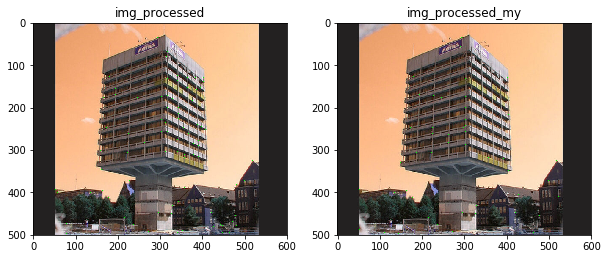

In [8]:
fig2 = plt.figure( figsize=(10, 10) )

ax1 = fig2.add_subplot(1,2,1)
ax1.imshow(img_processed, interpolation="none")
ax1.set_title("img_processed")

ax2 = fig2.add_subplot(1,2,2)
ax2.imshow(img_processed_my, interpolation="none")
ax2.set_title("img_processed_my")

plt.show()

### Shi-Tomasi Corner Detection